#  **Object-Oriented Implementation of a Pairs Trading Strategy**
*To what extent can a pairs trading system be designed and implemented to deliver consistent, scalable returns for retail investors in the stock market?*

**Author**: Dario Lucas Patzi Chavez, Student ID: 177125

**Course**: KAN-CDSCO2402U Programming, Algorithms and Data Structures

**Examiner**: Somnath Mazumdar

## Code for pairs Trading

### 1. Intalling and Importing

This section imports all the required libraries and tools, such as pandas for data manipulation, yfinance for stock data retrieval, and statistical libraries for testing cointegration.

In [ ]:
# Jupyter
#!pip install yfinance
#!pip install pandas
#!pip install matplotlib
#!pip install statsmodels

# VSCode
pip install yfinance
pip install pandas
pip install matplotlib
pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 4.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 1.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp312-cp312-macosx_11_0_arm64.whl size=264236 sha256=8dbfe92a37d40a9bad4cb78264f894e6afc75f858e89f13e69c4e48d7c92aefc
  Stored in directory: /Users/dariopatzi/Library/Caches/pip/wheels/8f/65/34/456800445efeafb05164fe95285c70e81ba1d96bae30f43917
Successfully built peewee


In [7]:
import yfinance as yf
import pandas as pd
import os
from io import StringIO
import time
from itertools import combinations
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

### 2. Loading Dataset from Wharton Research Data Services (WRDS)
This section reads a CSV file containing S&P 500 stock symbols. The Data is downloaded from WRDS.

In [9]:
SP500_df = pd.read_csv("SP500_names.csv")
SP500_df

,indexname,tic,companyname
0,S&P 500,BALL,Ball Corporation
1,S&P 500,BAC,Bank of America Corporation
2,S&P 500,MMM,3M Company
3,S&P 500,AOS,A. O. Smith Corporation
4,S&P 500,AME,"AMETEK, Inc."
...,...,...,...
498,S&P 500,YUM,"Yum! Brands, Inc."
499,S&P 500,ZBRA,Zebra Technologies Corporation
500,S&P 500,ZBH,"Zimmer Biomet Holdings, Inc."
501,S&P 500,ZTS,Zoetis Inc.


### 3. Classes

This Section contains all the classes used to implement the Pairs Trading Strategy. 

#### 3.1 StockData

The StockData class is responsible for fetching and processing stock data from Yahoo Finance. It is initialized with a stock symbol, which is used to download historical data. The fetch_data method retrieves stock prices for the last three months at hourly intervals, focusing on the "Adjusted Close" column. The data is cleaned by removing any missing values and saved as a CSV file in a designated folder for future use. 

The get_data method first checks if a saved CSV file exists. If found, it loads the data from the file. If no file is available or loading fails, it fetches fresh data using fetch_data. This class simplifies stock data handling by automating the download, cleaning, and storage process.

In [13]:
class StockData:
    """
    A class to fetch and preprocess stock data from Yahoo Finance.

    Attributes:
        symbol (str): The stock symbol for which data is fetched.
        data (pd.DataFrame): The preprocessed stock data.
    """

    def __init__(self, symbol):
        """
        Initialize the StockData class with a stock symbol.

        Args:
            symbol (str): The stock symbol to fetch data for.
        """
        # initialize the class with a stock symbol
        self.symbol = symbol
        self.data = None

    def fetch_data(self):
        """
        Fetch and preprocess stock data from Yahoo Finance.

        This method downloads historical stock data for the last 3 months 
        at 1-hour intervals, cleans it, and saves it as a CSV file.
        """
        print(f"Fetching data for {self.symbol} from Yahoo Finance...")
        try:
            # download data in 1-hour intervals for the past 3 months
            df = yf.download(self.symbol, interval='1h', period='3mo', progress=False)
            if df.empty:
                raise ValueError(f"No data found for {self.symbol}.")
            
            # extract the "Adj Close" column for further use
            if isinstance(df.columns, pd.MultiIndex):
                df = df["Adj Close"]  # handle MultiIndex if present
            elif "Adj Close" in df.columns:
                df = df[["Adj Close"]]  # select only "Adj Close" column
            else:
                raise ValueError(f"'Adj Close' column not found for {self.symbol}.")
            
            # rename column to "adjusted_close" for consistency
            df.columns = ["adjusted_close"]
            # ensure the index is labeled as 'timestamp'
            df.index.name = "timestamp"

            # clean and prepare the data
            self.data = df.dropna()  # remove rows with missing values

            # create a folder to save the data
            save_folder = os.path.join(os.getcwd(), "data_files")
            os.makedirs(save_folder, exist_ok=True)

            # save the cleaned data to a CSV file
            file_name = os.path.join(save_folder, f"{self.symbol}_data.csv")
            df.to_csv(file_name, index=True, header=True)
            print(f"Data for {self.symbol} saved to {file_name}.")

        except Exception as e:
            # handle errors during data fetching
            print(f"Error fetching data for {self.symbol}: {e}")

    def get_data(self):
        """
        Retrieve stock data from a local CSV file or fetch it if unavailable.

        Returns:
            pd.DataFrame: The stock data.
        """
        # define the folder and file path for saved data
        save_folder = os.path.join(os.getcwd(), "data_files")
        file_name = os.path.join(save_folder, f"{self.symbol}_data.csv")

        if os.path.exists(file_name):
            # load data from a saved CSV file if it exists
            print(f"Loading data for {self.symbol} from {file_name}...")
            try:
                # read the CSV file and parse the 'timestamp' column
                self.data = pd.read_csv(file_name, index_col="timestamp", parse_dates=["timestamp"])
            except Exception as e:
                # fetch fresh data if there's an error reading the file
                print(f"Error loading data for {self.symbol}: {e}")
                self.fetch_data()
        else:
            # fetch fresh data if the file does not exist
            self.fetch_data()
        return self.data

#### 3.2 StockManager

The StockManager class provides methods to load stock symbols from a CSV file and fetch their historical data. The load_stock_symbols method reads a CSV file containing a 'tic' column, validates its existence, and extracts up to 100 stock symbols for analysis. Once the symbols are loaded, the fetch_stock_data method retrieves historical data for each symbol using the StockData class, storing the results in a dictionary. The method ensures rate limits are respected and handles exceptions for any failed downloads. Additionally, it validates that at least two stocks have valid data before proceeding.

In [16]:
class StockManager:
    """
    Manage stock symbol loading and data fetching.
    """

    def __init__(self):
        """
        Initialize the StockManager class.
        """
        self.stock_symbols = []

    def load_stock_symbols(self, basket_file):
        """
        Load stock symbols from a CSV file containing a 'tic' column.

        Args:
            basket_file (str): Path to the CSV file containing stock symbols.

        Raises:
            FileNotFoundError: If the specified file does not exist.
            ValueError: If the file does not contain a 'tic' column.

        Returns:
            list: A list of up to 100 stock symbols extracted from the file.
        """
        # check if the file exists
        if not os.path.exists(basket_file):
            raise FileNotFoundError(f"{basket_file} not found.")

        # read the CSV file into a DataFrame
        tickers_df = pd.read_csv(basket_file)

        # check if the required 'tic' column is present
        if 'tic' not in tickers_df.columns:
            raise ValueError("The CSV file must contain a column named 'tic'.")

        # extract up to 100 stock symbols from the 'tic' column
        self.stock_symbols = tickers_df['tic'].tolist()[:100]
        print(f"Loaded {len(self.stock_symbols)} stock symbols.")
        return self.stock_symbols

    def fetch_stock_data(self, stock_symbols):
        """
        Fetch stock data for a list of stock symbols and store it in a dictionary.

        Args:
            stock_symbols (list): List of stock symbols to fetch data for.

        Returns:
            dict: A dictionary where keys are stock symbols, and values are their data (DataFrame).

        Raises:
            Exception: If less than two stocks have valid data for analysis.
        """
        stock_data_dict = {}

        # iterate over the list of stock symbols
        for symbol in stock_symbols:
            try:
                time.sleep(1)  # pause to respect rate limits
                stock = StockData(symbol)  # initialize StockData object
                stock_data_dict[symbol] = stock.get_data()  # fetch and store stock data
            except Exception as e:
                print(f"Skipping {symbol}: {e}")

        # ensure at least two stocks have valid data
        if len(stock_data_dict) < 2:
            raise Exception("Not enough stock data to perform analysis.")
        
        return stock_data_dict

#### 3.3 PairsFinder
The PairsFinder class identifies stock pairs using cointegration and correlation. The find_top_pairs method evaluates all stock pairs for cointegration, ranks them by p-value, and returns the top N pairs with the strongest cointegration. Similarly, find_top_pairs_with_correlation filters pairs by a correlation threshold before performing cointegration testing, selecting the top N based on p-values.

The find_top_pairs_quick_sort and find_top_pairs_with_correlation_quick_sort methods serve the same purpose as their counterparts but implement Quick Sort instead of Python's built-in sorting function, offering an alternative sorting algorithm. These methods enable comparisons of sorting approaches. All methods report execution times, providing insights into computational performance.

In [19]:
class PairsFinder:
    """
    A class to find stock pairs based on cointegration and correlation.
    """

    def __init__(self):
        """
        Initialize the PairsFinder class.
        """
        pass  # no specific initialization required

    def _get_cointegration_p_value(self, data1, data2):
        """
        calculate the cointegration p-value for two time series.

        Args:
            data1 (pd.Series): adjusted close data for the first ticker.
            data2 (pd.Series): adjusted close data for the second ticker.

        Returns:
            float: the cointegration p-value, or None if calculation fails.
        """
        try:
            # calculate cointegration p-value
            _, p_value, _ = coint(data1, data2)
            return p_value
        except Exception:
            return None

    def _filter_and_test_pairs(self, stock_data_dict, correlation_threshold=None):
        """
        filter and test stock pairs based on correlation and cointegration.

        Args:
            stock_data_dict (dict): dictionary of stock data.
            correlation_threshold (float, optional): correlation threshold to filter pairs.

        Returns:
            list: list of tuples containing (ticker1, ticker2, p_value).
        """
        pairs = []  # store valid pairs
        stock_pairs = list(combinations(stock_data_dict.keys(), 2))  # generate all stock pairs

        for ticker1, ticker2 in stock_pairs:
            # get data for both tickers
            data1, data2 = stock_data_dict.get(ticker1), stock_data_dict.get(ticker2)
            if data1 is None or data2 is None:  # skip if data is missing
                continue

            # extract adjusted close prices
            data1 = data1['adjusted_close']
            data2 = data2['adjusted_close']

            # align data for both tickers
            data1, data2 = data1.align(data2, join='inner')

            # skip pairs with insufficient data points
            if len(data1) < 30 or len(data2) < 30:
                continue

            # drop rows with missing values
            data1, data2 = data1.dropna(), data2.dropna()
            if data1.empty or data2.empty:  # skip if no valid data remains
                continue

            # filter based on correlation threshold if specified
            if correlation_threshold is not None:
                correlation = data1.corr(data2)  # calculate correlation
                if abs(correlation) < correlation_threshold:  # skip if below threshold
                    continue

            # calculate cointegration p-value
            p_value = self._get_cointegration_p_value(data1, data2)
            if p_value is not None:  # add valid pair to the list
                pairs.append((ticker1, ticker2, p_value))

        return pairs

    def _sort_and_select_top_pairs(self, pairs, top_n, quick_sort=False):
        """
        sort pairs by p-value and select the top N.

        Args:
            pairs (list): list of tuples (ticker1, ticker2, p_value).
            top_n (int): number of top pairs to return.
            quick_sort (bool): whether to use Quick Sort.

        Returns:
            list: top N sorted pairs.
        """
        # sort pairs using quick sort or default sorted function
        if quick_sort:
            return self.quick_sort_pairs(pairs)[:top_n]
        return sorted(pairs, key=lambda x: x[2])[:top_n]

    def quick_sort_pairs(self, pairs):
        """
        sort pairs by p-value using Quick Sort.

        Args:
            pairs (list): list of tuples representing stock pairs and their p-values.

        Returns:
            list: sorted list of pairs.
        """
        if len(pairs) <= 1:  # base case for recursion
            return pairs

        # choose pivot as the middle element's p-value
        pivot = pairs[len(pairs) // 2][2]
        # partition into left, middle, and right
        left = [x for x in pairs if x[2] < pivot]
        middle = [x for x in pairs if x[2] == pivot]
        right = [x for x in pairs if x[2] > pivot]

        # recursively sort left and right, then combine
        return self.quick_sort_pairs(left) + middle + self.quick_sort_pairs(right)

    def find_top_pairs(self, stock_data_dict, top_n=3):
        """
        find the top N pairs with the lowest p-values using default sorting.

        Args:
            stock_data_dict (dict): dictionary of stock data.
            top_n (int): number of top pairs to return.

        Returns:
            list: top N pairs sorted by p-value.
        """
        start_time = time.time()  # start timing

        # filter and test pairs without correlation filtering
        pairs = self._filter_and_test_pairs(stock_data_dict)

        # sort and select top pairs
        top_pairs = self._sort_and_select_top_pairs(pairs, top_n)

        # print the top pairs
        print("\nTop pairs based on p-values using Quick Sort:")
        for rank, (ticker1, ticker2, p_value) in enumerate(top_pairs, start=1):
            print(f"{rank}. {ticker1} & {ticker2} - p-value: {p_value:.5f}")
        
        # calculate and display elapsed time
        elapsed_time = time.time() - start_time
        print(f"Time taken to find top pairs: {elapsed_time:.2f} seconds")
        return top_pairs

    def find_top_pairs_with_correlation(self, stock_data_dict, correlation_threshold=0.8, top_n=3):
        """
        find the top N pairs based on correlation and default sorting.

        Args:
            stock_data_dict (dict): dictionary of stock data.
            correlation_threshold (float): correlation threshold.
            top_n (int): number of top pairs to return.

        Returns:
            list: top N pairs sorted by p-value.
        """
        start_time = time.time()  # start timing

        # filter and test pairs with correlation filtering
        pairs = self._filter_and_test_pairs(stock_data_dict, correlation_threshold)

        # sort and select top pairs
        top_pairs = self._sort_and_select_top_pairs(pairs, top_n)

        # print the top pairs
        print("\nTop pairs based on p-values using Quick Sort:")
        for rank, (ticker1, ticker2, p_value) in enumerate(top_pairs, start=1):
            print(f"{rank}. {ticker1} & {ticker2} - p-value: {p_value:.5f}")

        # calculate and display elapsed time
        elapsed_time = time.time() - start_time
        print(f"Time taken to find top pairs with correlation: {elapsed_time:.2f} seconds")
        return top_pairs

    def find_top_pairs_quick_sort(self, stock_data_dict, top_n=3):
        """
        find the top N pairs with the lowest p-values using Quick Sort.

        Args:
            stock_data_dict (dict): dictionary of stock data.
            top_n (int): number of top pairs to return.

        Returns:
            list: top N pairs sorted by p-value.
        """
        start_time = time.time()  # start timing

        # filter and test pairs without correlation filtering
        pairs = self._filter_and_test_pairs(stock_data_dict)

        # sort and select top pairs using Quick Sort
        top_pairs = self._sort_and_select_top_pairs(pairs, top_n, quick_sort=True)

        # print the top pairs
        print("\nTop pairs based on p-values using Quick Sort:")
        for rank, (ticker1, ticker2, p_value) in enumerate(top_pairs, start=1):
            print(f"{rank}. {ticker1} & {ticker2} - p-value: {p_value:.5f}")

        # calculate and display elapsed time
        elapsed_time = time.time() - start_time
        print(f"Time taken to find and sort top pairs with Quick Sort: {elapsed_time:.2f} seconds")
        return top_pairs

    def find_top_pairs_with_correlation_quick_sort(self, stock_data_dict, correlation_threshold=0.8, top_n=3):
        """
        find the top N pairs based on correlation using Quick Sort.

        Args:
            stock_data_dict (dict): dictionary of stock data.
            correlation_threshold (float): correlation threshold.
            top_n (int): number of top pairs to return.

        Returns:
            list: top N pairs sorted by p-value.
        """
        start_time = time.time()  # start timing

        # filter and test pairs with correlation filtering
        pairs = self._filter_and_test_pairs(stock_data_dict, correlation_threshold)

        # sort and select top pairs using Quick Sort
        top_pairs = self._sort_and_select_top_pairs(pairs, top_n, quick_sort=True)

        # print the top pairs
        print("\nTop pairs based on p-values using Quick Sort:")
        for rank, (ticker1, ticker2, p_value) in enumerate(top_pairs, start=1):
            print(f"{rank}. {ticker1} & {ticker2} - p-value: {p_value:.5f}")

        # calculate and display elapsed time
        elapsed_time = time.time() - start_time
        print(f"Time taken to find top pairs with correlation (Quick Sort): {elapsed_time:.2f} seconds")
        return top_pairs

#### 3.4 SignalAnalyzer

The SignalAnalyzer class generates trading signals and calculates the profits. The signals_zscore_evolution method calculates Z-scores by analyzing the rolling ratio of two stock time series and generates trading signals based on these scores. This process helps identify buy (long) and sell (short) opportunities.

The calculate_profits_with_stop_loss method simulates the trading process using these signals, allocating a fraction of available cash for trades and dynamically updating portfolio positions. The method includes a stop-loss mechanism to exit trades when price deviations exceed a predefined threshold. This approach provides detailed insights into trading performance by returning the final cash balance, a trade log, the total number of trades executed, and the portfolio value over time. 

In [22]:
class SignalAnalyzer:
    """
    A class to analyze trading signals and calculate profits for pairs trading.

    Attributes:
        window_size (int): Rolling window size for calculating Z-scores.
    """

    def __init__(self, window_size=48):
        """
        Initialize the SignalAnalyzer with a window size.

        Args:
            window_size (int): The rolling window size for mean and standard deviation calculation.
        """
        self.window_size = window_size

    def signals_zscore_evolution(self, ticker1_ts, ticker2_ts):
        """
        Generate Z-score signals for a pair of time series.

        This function calculates the rolling Z-scores of the ratio between two time series
        over a specified window and generates trading signals based on threshold levels.

        Args:
            ticker1_ts (pd.Series): Time series of the first ticker's prices.
            ticker2_ts (pd.Series): Time series of the second ticker's prices.

        Returns:
            pd.DataFrame: A DataFrame containing Z-scores and corresponding trading signals.
                          - 'z_score': Calculated Z-scores of the price ratios.
                          - 'signal': Trading signals:
                              - 1: Indicates a long position.
                              - -1: Indicates a short position.
                              - 0: No trade signal.
        """
        # calculate the ratio between the two time series
        ratios = ticker1_ts / ticker2_ts

        # calculate rolling mean and standard deviation of the ratio
        ratios_mean = ratios.rolling(window=self.window_size).mean()
        ratios_std = ratios.rolling(window=self.window_size).std()

        # calculate Z-scores for the ratio
        z_scores = (ratios - ratios_mean) / (ratios_std + 1e-8)

        # create a DataFrame to store Z-scores and trading signals
        signals_df = pd.DataFrame(index=ticker1_ts.index)
        signals_df['z_score'] = z_scores

        # initialize signal column with no trade (0)
        signals_df['signal'] = 0

        # generate trading signals based on Z-score thresholds
        signals_df.loc[z_scores > 1, 'signal'] = -1  # short position when Z > 1
        signals_df.loc[z_scores < -1, 'signal'] = 1   # long position when Z < -1

        return signals_df

    def calculate_profits_with_stop_loss(
        self, ticker1_ts, ticker2_ts, signals_df, cash, stop_loss_threshold, trade_fraction, ticker1_name='', ticker2_name=''
    ):
        """
        Calculate profits for pairs trading with stop-loss functionality.

        Args:
            ticker1_ts (pd.Series): Time series of prices for ticker1.
            ticker2_ts (pd.Series): Time series of prices for ticker2.
            signals_df (pd.DataFrame): Z-score signals and corresponding trade signals.
            cash (float): Initial cash for trading.
            stop_loss_threshold (float): Stop-loss threshold as a percentage.
            trade_fraction (float): Fraction of cash to use per trade.
            ticker1_name (str): Name of ticker1 (optional).
            ticker2_name (str): Name of ticker2 (optional).

        Returns:
            float: Final cash after trading.
            list: Trade log detailing entries, exits, and stop-losses.
            int: Total number of trades executed.
            pd.Series: Portfolio value over time.
        """
        position = 0  # current position: 1 for long, -1 for short, 0 for neutral
        trade_log = []  # log of all trades
        trade_count = 0  # total trades executed
        ticker1_prices = ticker1_ts.values
        ticker2_prices = ticker2_ts.values
        portfolio_value = []  # track portfolio value over time
        shares_ticker1 = 0  # number of shares bought for ticker1
        shares_ticker2 = 0  # number of shares bought for ticker2
        entry_price_ticker1 = None  # entry price for ticker1
        entry_price_ticker2 = None  # entry price for ticker2

        # iterate over each signal
        for i in range(len(signals_df)):
            signal = signals_df.iloc[i]["signal"]
            price_ticker1 = ticker1_prices[i]
            price_ticker2 = ticker2_prices[i]
            trade_size = cash * trade_fraction  # available cash for this trade

            # skip invalid or zero price values
            if price_ticker1 <= 0 or price_ticker2 <= 0:
                continue

            # stop-loss logic
            if position != 0:
                price_ratio = price_ticker2 / price_ticker1
                deviation = abs(price_ratio - (entry_price_ticker2 / entry_price_ticker1)) / (entry_price_ticker2 / entry_price_ticker1)
                if deviation > stop_loss_threshold:
                    # calculate profit/loss for stop-loss exit
                    exit_profit_t1 = (price_ticker1 - entry_price_ticker1) * shares_ticker1
                    exit_profit_t2 = (entry_price_ticker2 - price_ticker2) * shares_ticker2
                    total_profit_loss = exit_profit_t1 + exit_profit_t2
                    cash += total_profit_loss
                    # log stop-loss exit
                    trade_log.append(
                        f"Stop-loss triggered: {ticker1_name}=${price_ticker1:.2f} ({shares_ticker1} shares), "
                        f"{ticker2_name}=${price_ticker2:.2f} ({shares_ticker2} shares) | "
                        f"Profit/Loss: {'+' if total_profit_loss > 0 else ''}{total_profit_loss:.2f}"
                    )
                    position = 0  # reset position
                    shares_ticker1, shares_ticker2 = 0, 0
                    trade_count += 1

            # entry logic for long or short positions
            if signal == 1 and position != 1:  # long entry
                shares_ticker1 = int(trade_size / price_ticker1)
                shares_ticker2 = int(trade_size / price_ticker2)
                entry_price_ticker1, entry_price_ticker2 = price_ticker1, price_ticker2
                trade_log.append(
                    f"Long Entry: {ticker1_name}=${price_ticker1:.2f} ({shares_ticker1} shares), "
                    f"{ticker2_name}=${price_ticker2:.2f} ({shares_ticker2} shares)"
                )
                position = 1
                trade_count += 1
            elif signal == -1 and position != -1:  # short entry
                shares_ticker1 = int(trade_size / price_ticker1)
                shares_ticker2 = int(trade_size / price_ticker2)
                entry_price_ticker1, entry_price_ticker2 = price_ticker1, price_ticker2
                trade_log.append(
                    f"Short Entry: {ticker1_name}=${price_ticker1:.2f} ({shares_ticker1} shares), "
                    f"{ticker2_name}=${price_ticker2:.2f} ({shares_ticker2} shares)"
                )
                position = -1
                trade_count += 1

            # close position logic
            elif signal == 0 and position != 0:
                exit_profit_t1 = (price_ticker1 - entry_price_ticker1) * shares_ticker1 * position
                exit_profit_t2 = (entry_price_ticker2 - price_ticker2) * shares_ticker2 * position
                total_profit_loss = exit_profit_t1 + exit_profit_t2
                cash += total_profit_loss
                # log close position
                trade_log.append(
                    f"Close Position: {ticker1_name}=${price_ticker1:.2f} ({shares_ticker1} shares), "
                    f"{ticker2_name}=${price_ticker2:.2f} ({shares_ticker2} shares) | "
                    f"Profit/Loss: {'+' if total_profit_loss > 0 else ''}{total_profit_loss:.2f}"
                )
                position = 0  # reset position
                shares_ticker1, shares_ticker2 = 0, 0
                trade_count += 1

            # append current cash to portfolio value
            portfolio_value.append(cash)

        # return results
        return cash, trade_log, trade_count, pd.Series(portfolio_value, index=signals_df.index)


#### 3.5 PairsTradingManager

The PairsTradingManager class handles the entire trading process, from analyzing signals to tracking portfolio performance. It starts by aligning price data for the top pairs and initializing the portfolio with the given capital. Using SignalAnalyzer, it calculates Z-scores to generate trade signals. The class applies stop-loss rules, tracks profits, and updates the portfolio's value. It also provides key results like trades executed, stop-loss triggers, and final portfolio values. Visualizations of Z-scores and portfolio changes are included for clarity. A summary and detailed trade log making the trading process more transparent.

In [25]:
class PairsTradingManager:
    """
    A class to manage the entire pairs trading process, including analyzing trading signals 
    and calculating portfolio performance.

    Attributes:
        initial_capital (float): Initial capital for each trading pair.
        stop_loss_threshold (float): Threshold for triggering stop-loss.
        trade_fraction (float): Fraction of capital allocated per trade.
    """

    def __init__(self, initial_capital, stop_loss_threshold, trade_fraction):
        """
        Initialize the PairsTradingManager with capital, stop-loss threshold, and trade fraction.

        Args:
            initial_capital (float): Initial capital for each trading pair.
            stop_loss_threshold (float): Threshold for triggering stop-loss.
            trade_fraction (float): Fraction of capital allocated per trade.
        """
        self.initial_capital = initial_capital
        self.stop_loss_threshold = stop_loss_threshold
        self.trade_fraction = trade_fraction

    def analyze_trading_signals(self, stock_data_dict, top_pairs):
        """
        Analyze trading signals for top pairs and calculate portfolio performance.

        Args:
            stock_data_dict (dict): Dictionary of stock data with adjusted close prices.
            top_pairs (list): List of top pairs (ticker1, ticker2, p_value).

        Returns:
            None: Prints results, logs, and visualizations.
        """
        combined_trade_logs = []  # log of all trades
        total_trades = 0  # total number of trades executed
        total_stop_loss_triggers = 0  # count of stop-loss triggers
        pair_portfolio_values = {}  # dictionary to store portfolio value series for each pair

        # display initial capital
        print(f"\n{'='*60}")
        print(f"Starting Portfolio Analysis with Initial Capital: ${self.initial_capital:.2f}")
        print(f"{'='*60}\n")

        for ticker1, ticker2, p_value in top_pairs:
            # print header for each pair
            print(f"\n{'-'*60}")
            print(f"Analyzing Pair: {ticker1} & {ticker2} | p-value: {p_value:.5f}")

            # fetch and align price data for both tickers
            data1, data2 = stock_data_dict[ticker1]['adjusted_close'], stock_data_dict[ticker2]['adjusted_close']
            data1, data2 = data1.align(data2, join='inner')

            # initialize cash and portfolio value
            cash = self.initial_capital
            portfolio_value = pd.Series(index=data1.index, dtype='float64')  # align portfolio index with data

            # generate Z-score signals
            signal_analyzer = SignalAnalyzer()  # use SignalAnalyzer for signal generation
            signals_df = signal_analyzer.signals_zscore_evolution(data1, data2)

            # calculate profits using stop-loss logic
            cash, trade_log, trade_count, portfolio_value = signal_analyzer.calculate_profits_with_stop_loss(
                data1, data2, signals_df, cash,
                self.stop_loss_threshold, self.trade_fraction,
                ticker1_name=ticker1, ticker2_name=ticker2
            )

            # ensure portfolio value index has the correct format
            if not isinstance(portfolio_value.index, pd.DatetimeIndex):
                print("Warning: Portfolio Value does not have a DatetimeIndex. Reassigning...")
                portfolio_value.index = data1.index
                print(f"Reassigned Portfolio Value Index Type: {type(portfolio_value.index)}")

            # count stop-loss triggers in the trade log
            stop_loss_count = sum(1 for log in trade_log if "Stop-loss triggered" in log)
            total_stop_loss_triggers += stop_loss_count

            # save portfolio values for this pair
            pair_portfolio_values[(ticker1, ticker2)] = portfolio_value

            # update overall statistics
            combined_trade_logs.extend(trade_log)
            total_trades += trade_count

            # print results for this pair
            print(f"Final Portfolio Value for {ticker1} & {ticker2}: ${cash:.2f}")
            print(f"Trades Executed: {trade_count}")
            print(f"Stop-Loss Triggers: {stop_loss_count}")

            # prepare data for visualization
            weekly_values = portfolio_value.resample('W').last()
            weekly_pct_change = weekly_values.pct_change() * 100

            # create subplots for Z-score and portfolio changes
            fig, axes = plt.subplots(1, 2, figsize=(18, 6))

            # plot Z-score on the left
            axes[0].plot(signals_df.index, signals_df['z_score'], label="Z-Score", color="gray")
            axes[0].axhline(1, color="red", linestyle="--", label="Upper Threshold (1)")
            axes[0].axhline(-1, color="red", linestyle="--", label="Lower Threshold (-1)")
            axes[0].axhline(0, color="black", linestyle="--", label="Mean")
            axes[0].set_title(f"Z-Score for {ticker1} & {ticker2}")
            axes[0].set_xlabel("Time")
            axes[0].set_ylabel("Z-Score")
            axes[0].legend()

            # plot weekly portfolio changes on the right
            positive_changes = weekly_pct_change[weekly_pct_change > 0]
            negative_changes = weekly_pct_change[weekly_pct_change <= 0]
            axes[1].bar(positive_changes.index, positive_changes, color='green', label='Positive Change')
            axes[1].bar(negative_changes.index, negative_changes, color='red', label='Negative Change')
            axes[1].axhline(0, color='black', linewidth=1, linestyle='--')
            axes[1].set_title(f"Weekly Percentage Change in Portfolio Value: {ticker1} & {ticker2}")
            axes[1].set_xlabel("Week")
            axes[1].set_ylabel("Percentage Change (%)")
            axes[1].legend()

            # adjust layout and display the plots
            plt.tight_layout()
            plt.show()

        # summary of results
        print(f"\n{'-'*60}")
        print("\nSummary of Results")
        for (ticker1, ticker2), portfolio_value in pair_portfolio_values.items():
            final_value = portfolio_value.dropna().iloc[-1] if not portfolio_value.empty else self.initial_capital
            percentage_change = ((final_value - self.initial_capital) / self.initial_capital) * 100
            print(f"Pair: {ticker1} & {ticker2}")
            print(f"  Final Portfolio Value: ${final_value:.2f}")
            print(f"  Percentage Change: {percentage_change:.2f}%")
        print(f"Total Trades Executed: {total_trades}")
        print(f"Total Stop-Loss Triggers: {total_stop_loss_triggers}")
        print(f"\n{'-'*60}")

        # print combined trade log
        print("\nCombined Trade Log")
        print(f"{'-'*60}")
        for trade in combined_trade_logs:
            print(trade)
        print(f"{'-'*60}")


### 4. Applying the pairs trading strategy

In this section, we will apply the previously defined classes to implement the pairs trading strategy. First in section 5.1, we will verify if the stock symbols load correctly. Next in section 5.2, we will fetch the stock data using Yahoo Finance (yfinance) or load it directly from the environment if it was previously saved. Following this, the strategy will be executed first using the standard sorting method in section 5.3 and then using the quick sorting approach in section 5.4. This comparison will allow us to evaluate whether quick sorting can save time while still identifying effective trading pairs.

#### 4.1 Load stock symbols

This function, load_stock_symbols, extracts stock symbols from the loaded S&P500 CSV file. It ensures the file exists and verifies that it contains a required column named 'tic'. Up to 100 stock symbols are then retrieved from this column and returned as a list. The function is essential for initializing stock symbol data for analysis and raises errors if the file is missing or improperly formatted.

In [44]:
basket_file = "SP500_names.csv"
stock_manager = StockManager()
print("Step 1: Loading stock symbols...")
stock_symbols = stock_manager.load_stock_symbols(basket_file)


Step 1: Loading stock symbols...
Loaded 100 stock symbols.


#### 4.2 Fetching the stock data through yFinance or load it from local folder
If you want to try the api download you have to delete the folder data_files in the main folder 

In [51]:
print("\nStep 2: Fetching stock data...")
stock_data_dict = stock_manager.fetch_stock_data(stock_symbols)


Step 2: Fetching stock data...
Loading data for BALL from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BALL_data.csv...
Loading data for BAC from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BAC_data.csv...
Loading data for MMM from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/MMM_data.csv...
Loading data for AOS from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/AOS_data.csv...
Loading data for AME from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/AME_data.csv...
Loading data for ANSS from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/ANSS_data.csv...
Loading data for APA from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/APA_data.csv...
Loading data for T from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/T_data.csv...
Loading data for ABBV from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/ABBV_data.csv...
Loading data for ABT from /Users/dariopatzi/Desk


1 Failed download:
['BRK.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")')


Error fetching data for BRK.B: No data found for BRK.B.
Loading data for BBY from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BBY_data.csv...
Loading data for TECH from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/TECH_data.csv...
Loading data for BIIB from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BIIB_data.csv...
Loading data for BLK from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BLK_data.csv...
Loading data for BX from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BX_data.csv...
Loading data for BKNG from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BKNG_data.csv...
Loading data for BWA from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BWA_data.csv...
Loading data for BSX from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BSX_data.csv...
Loading data for BMY from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BMY_data.csv...
Loading data for AVGO 


1 Failed download:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=3mo)')


Fetching data for BF.B from Yahoo Finance...
Error fetching data for BF.B: No data found for BF.B.
Loading data for BLDR from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BLDR_data.csv...
Loading data for BG from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/BG_data.csv...
Loading data for CHRW from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/CHRW_data.csv...
Loading data for CBRE from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/CBRE_data.csv...
Loading data for CDW from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/CDW_data.csv...
Loading data for CF from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/CF_data.csv...
Loading data for CME from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/CME_data.csv...
Loading data for CMS from /Users/dariopatzi/Desktop/Programming_Assignment/data_files/CMS_data.csv...
Loading data for CSX from /Users/dariopatzi/Desktop/Programming_Assignment/data_fil

#### 4.3 Find suitable pairs to trade

##### 4.3.1 Python standard sorting

In [53]:
pairs_finder = PairsFinder()

print("\nFinding top pairs (Standard python sorting)...")
top_pairs = pairs_finder.find_top_pairs(stock_data_dict, top_n=3)

print(f"\n{'-'*60}")

print("\nFinding top pairs (Correlation filtering and standard python sorting)...")
top_pairs_corr = pairs_finder.find_top_pairs_with_correlation(stock_data_dict, correlation_threshold=0.9, top_n=3)



Finding top pairs (Standard python sorting)...

Top pairs based on p-values using Quick Sort:
1. BSX & BR - p-value: 0.00085
2. BLDR & CARR - p-value: 0.00153
3. AOS & BBY - p-value: 0.00195
Time taken to find top pairs: 16.94 seconds

------------------------------------------------------------

Finding top pairs (Correlation filtering and standard python sorting)...

Top pairs based on p-values using Quick Sort:
1. BSX & BR - p-value: 0.00085
2. BLDR & CARR - p-value: 0.00153
3. AOS & BBY - p-value: 0.00195
Time taken to find top pairs with correlation: 1.06 seconds


##### 4.3.2 Quick Sorting

In [55]:
pairs_finder = PairsFinder()

print("\nFinding top pairs (Quick Sort)...")
top_pairs_quick_sort = pairs_finder.find_top_pairs_quick_sort(stock_data_dict, top_n=3)

print(f"\n{'-'*60}")

print("\nFinding top pairs (Correlation filtering and Quick Sort)...")
top_pairs_corr_quick_sort = pairs_finder.find_top_pairs_with_correlation_quick_sort(
    stock_data_dict, correlation_threshold=0.9, top_n=3
)


Finding top pairs (Quick Sort)...

Top pairs based on p-values using Quick Sort:
1. BSX & BR - p-value: 0.00085
2. BLDR & CARR - p-value: 0.00153
3. AOS & BBY - p-value: 0.00195
Time taken to find and sort top pairs with Quick Sort: 17.12 seconds

------------------------------------------------------------

Finding top pairs (Correlation filtering and Quick Sort)...

Top pairs based on p-values using Quick Sort:
1. BSX & BR - p-value: 0.00085
2. BLDR & CARR - p-value: 0.00153
3. AOS & BBY - p-value: 0.00195
Time taken to find top pairs with correlation (Quick Sort): 1.04 seconds


#### 4.4 Trading Anaylsis and Performance


Analyzing signals and portfolio performance (Top pairs from python standard sorting)...

Starting Portfolio Analysis with Initial Capital: $1000000.00


------------------------------------------------------------
Analyzing Pair: BSX & BR | p-value: 0.00085
Final Portfolio Value for BSX & BR: $1008562.79
Trades Executed: 75
Stop-Loss Triggers: 0


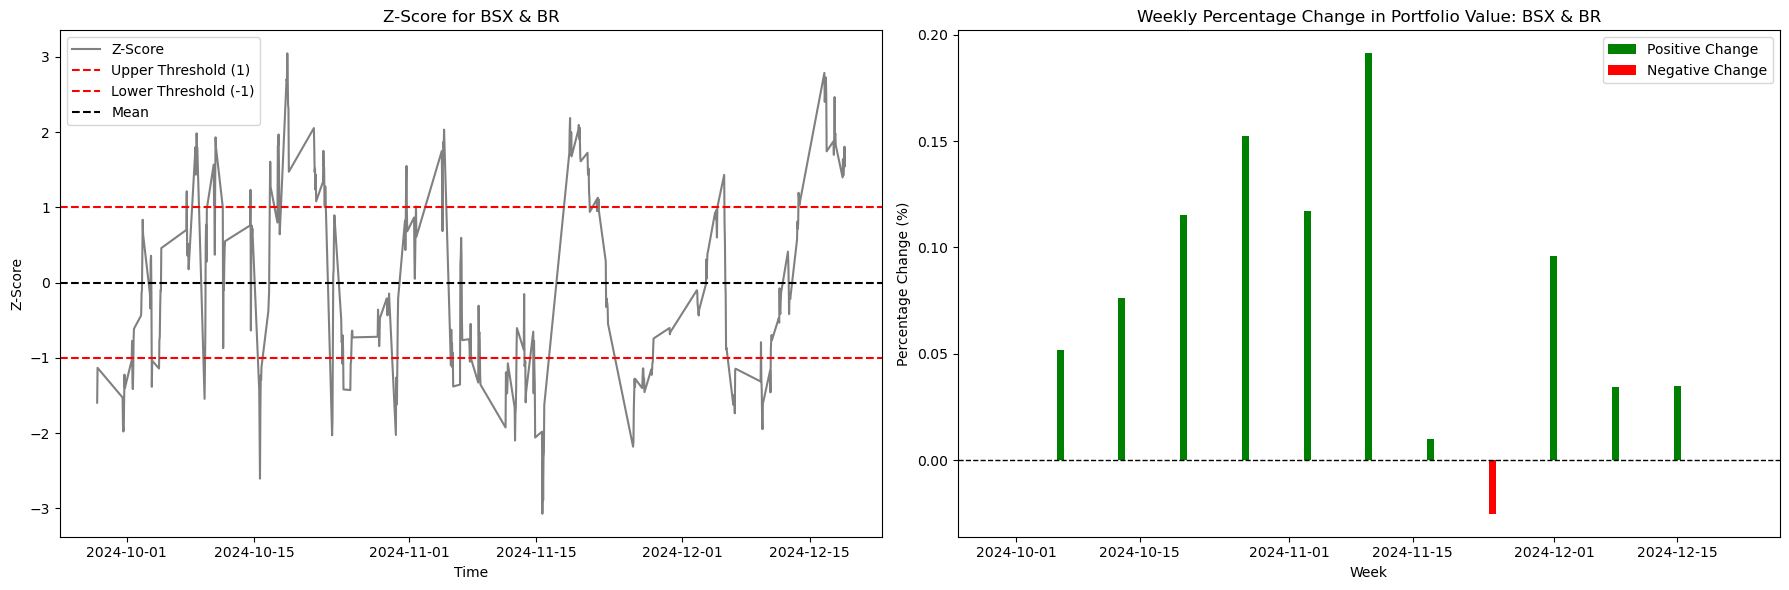


------------------------------------------------------------
Analyzing Pair: BLDR & CARR | p-value: 0.00153
Final Portfolio Value for BLDR & CARR: $1010031.60
Trades Executed: 71
Stop-Loss Triggers: 0


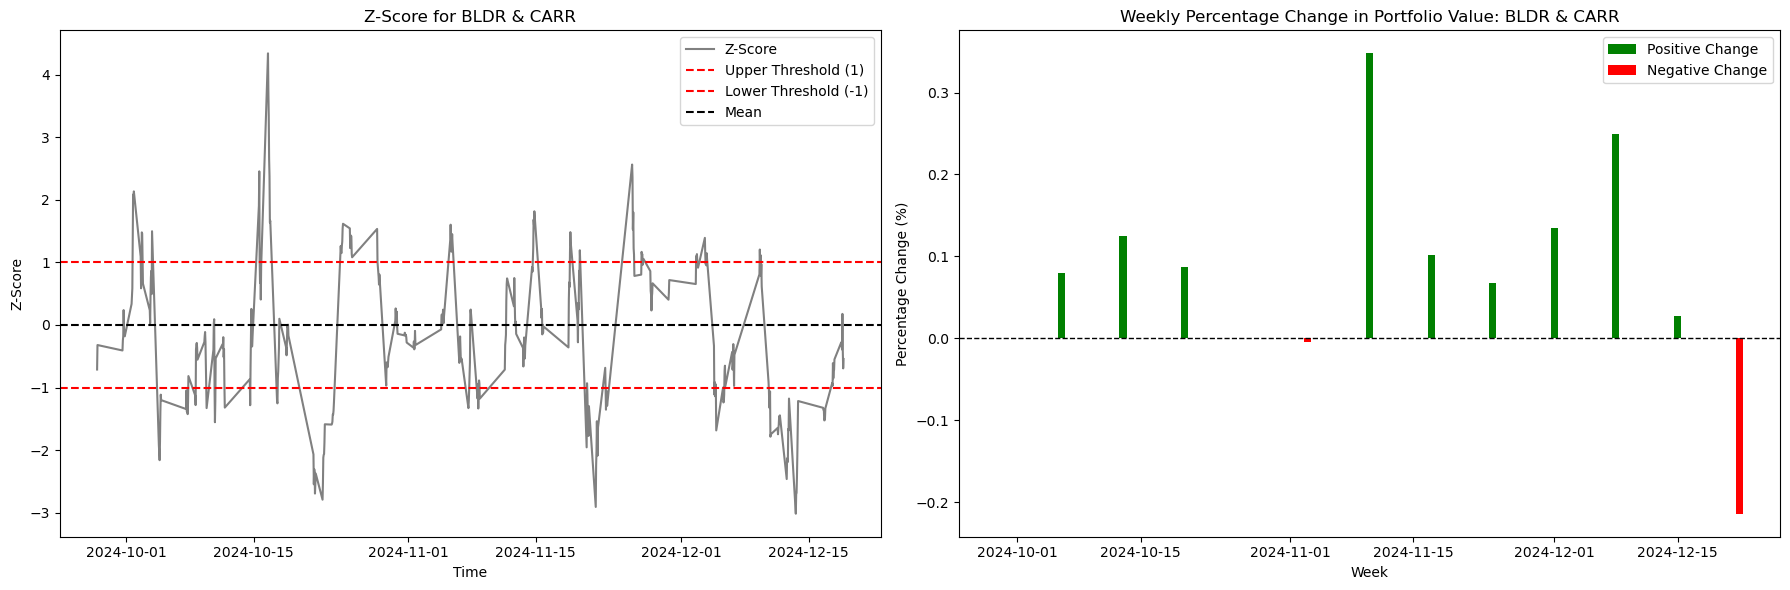


------------------------------------------------------------
Analyzing Pair: AOS & BBY | p-value: 0.00195
Final Portfolio Value for AOS & BBY: $1009824.34
Trades Executed: 52
Stop-Loss Triggers: 0


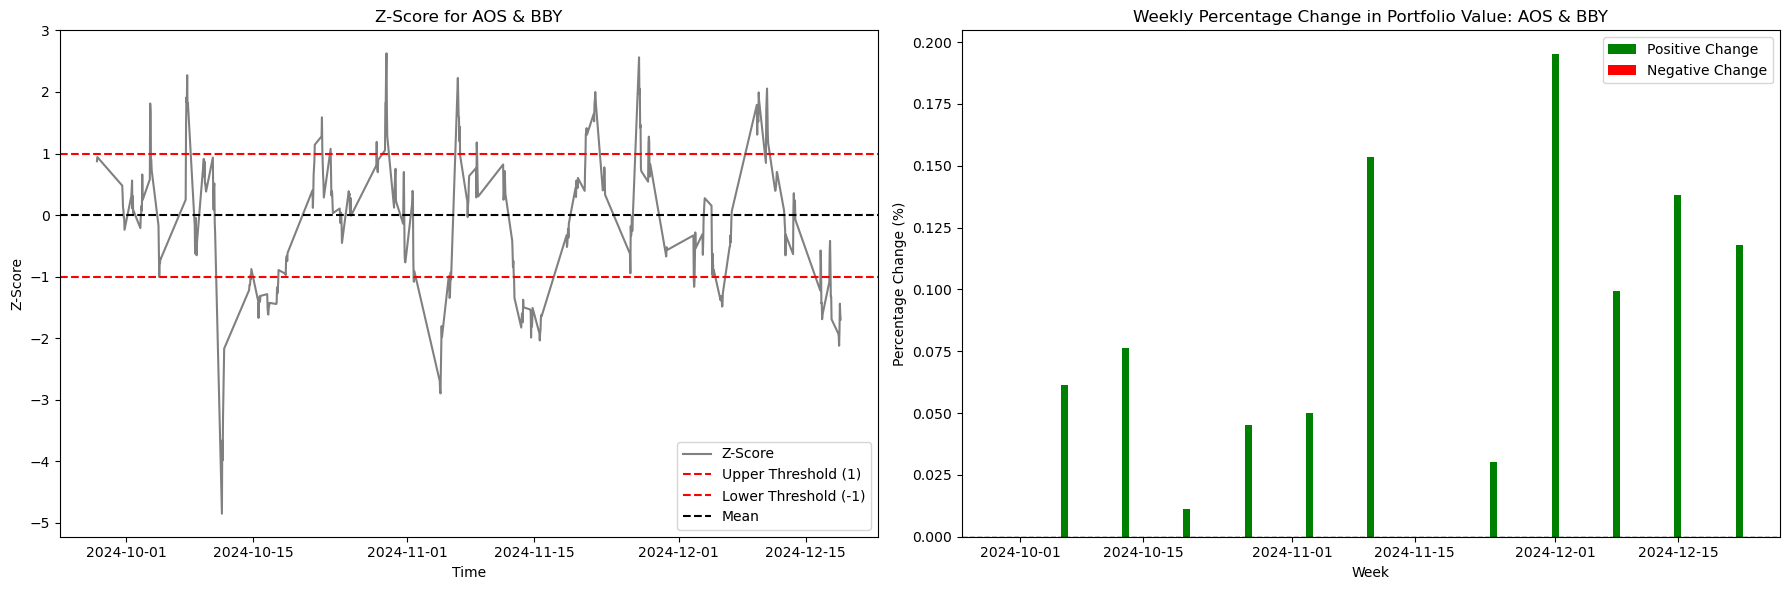


------------------------------------------------------------

Summary of Results
Pair: BSX & BR
  Final Portfolio Value: $1008562.79
  Percentage Change: 0.86%
Pair: BLDR & CARR
  Final Portfolio Value: $1010031.60
  Percentage Change: 1.00%
Pair: AOS & BBY
  Final Portfolio Value: $1009824.34
  Percentage Change: 0.98%
Total Trades Executed: 198
Total Stop-Loss Triggers: 0

------------------------------------------------------------

Combined Trade Log
------------------------------------------------------------
Long Entry: BSX=$83.20 (600 shares), BR=$212.57 (235 shares)
Close Position: BSX=$84.04 (600 shares), BR=$214.29 (235 shares) | Profit/Loss: +99.81
Long Entry: BSX=$83.69 (597 shares), BR=$214.78 (232 shares)
Close Position: BSX=$84.09 (597 shares), BR=$214.80 (232 shares) | Profit/Loss: +235.65
Long Entry: BSX=$83.48 (599 shares), BR=$214.62 (233 shares)
Close Position: BSX=$83.25 (599 shares), BR=$213.25 (233 shares) | Profit/Loss: +181.44
Short Entry: BSX=$84.95 (588 shar

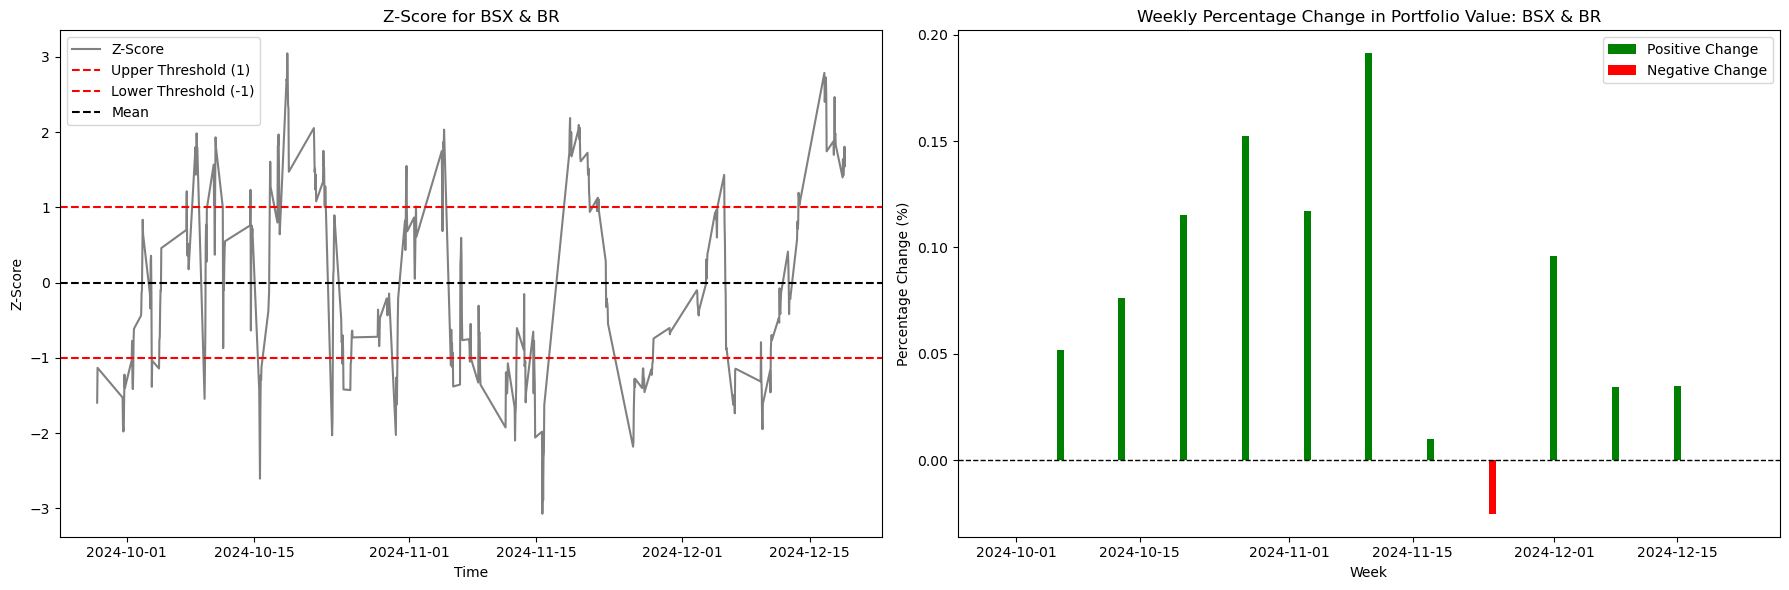


------------------------------------------------------------
Analyzing Pair: BLDR & CARR | p-value: 0.00153
Final Portfolio Value for BLDR & CARR: $1010031.60
Trades Executed: 71
Stop-Loss Triggers: 0


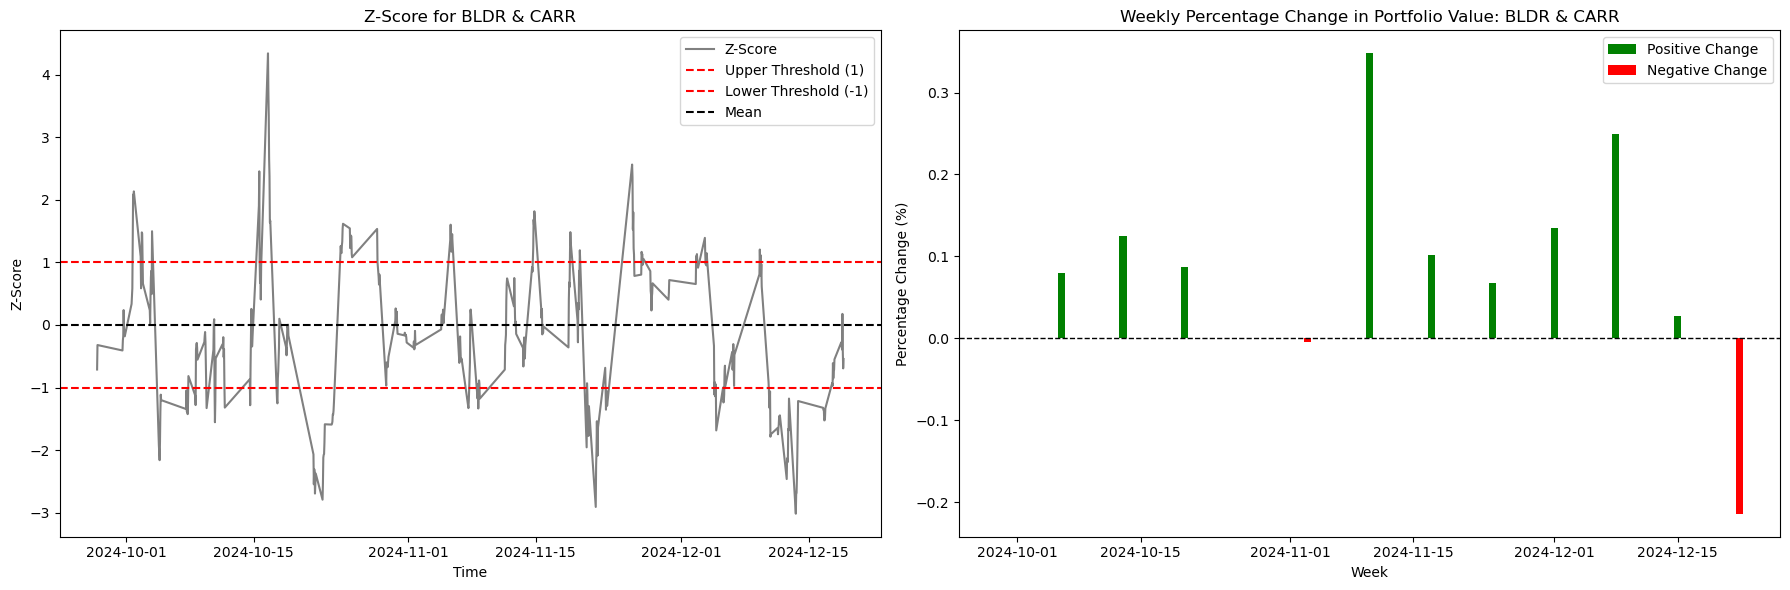


------------------------------------------------------------
Analyzing Pair: AOS & BBY | p-value: 0.00195
Final Portfolio Value for AOS & BBY: $1009824.34
Trades Executed: 52
Stop-Loss Triggers: 0


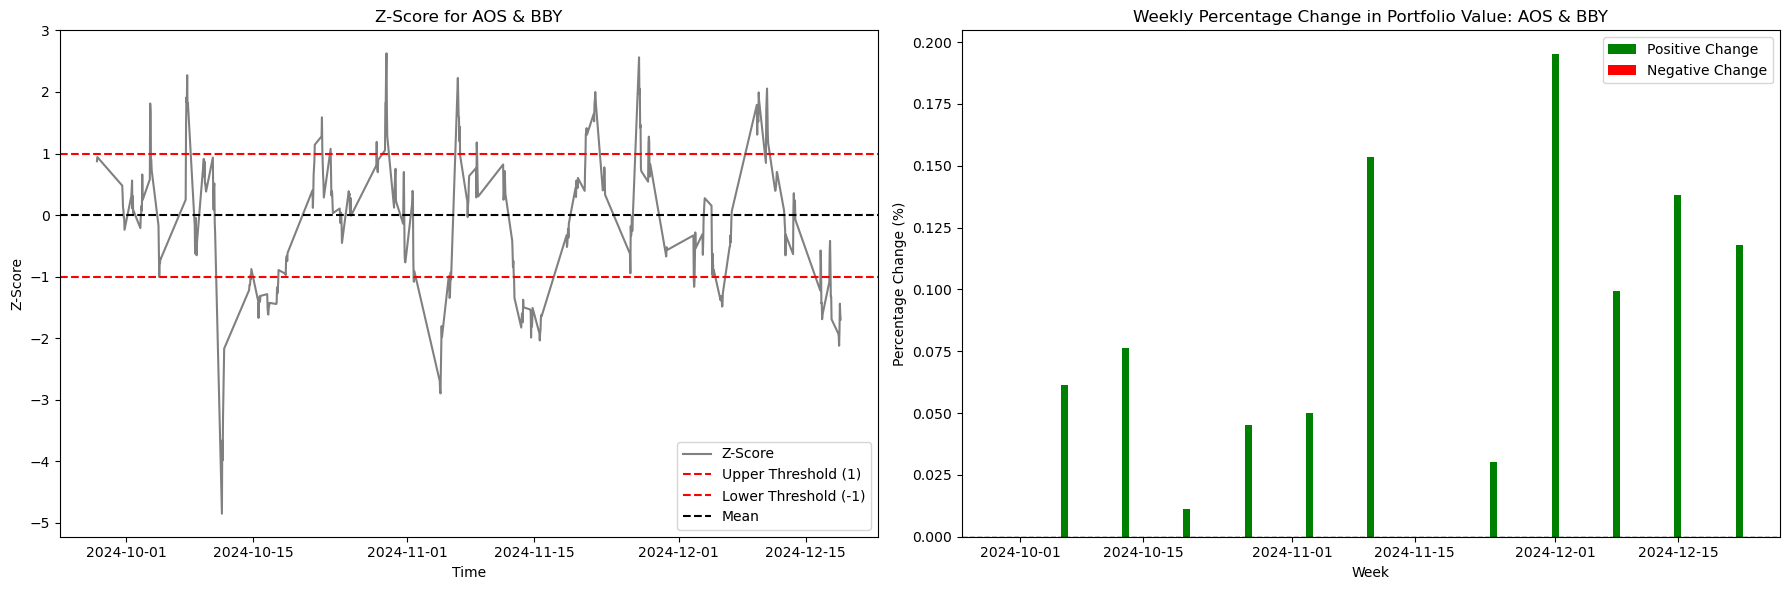


------------------------------------------------------------

Summary of Results
Pair: BSX & BR
  Final Portfolio Value: $1008562.79
  Percentage Change: 0.86%
Pair: BLDR & CARR
  Final Portfolio Value: $1010031.60
  Percentage Change: 1.00%
Pair: AOS & BBY
  Final Portfolio Value: $1009824.34
  Percentage Change: 0.98%
Total Trades Executed: 198
Total Stop-Loss Triggers: 0

------------------------------------------------------------

Combined Trade Log
------------------------------------------------------------
Long Entry: BSX=$83.20 (600 shares), BR=$212.57 (235 shares)
Close Position: BSX=$84.04 (600 shares), BR=$214.29 (235 shares) | Profit/Loss: +99.81
Long Entry: BSX=$83.69 (597 shares), BR=$214.78 (232 shares)
Close Position: BSX=$84.09 (597 shares), BR=$214.80 (232 shares) | Profit/Loss: +235.65
Long Entry: BSX=$83.48 (599 shares), BR=$214.62 (233 shares)
Close Position: BSX=$83.25 (599 shares), BR=$213.25 (233 shares) | Profit/Loss: +181.44
Short Entry: BSX=$84.95 (588 shar

In [57]:
pairs_trading_manager = PairsTradingManager(initial_capital=1000000, stop_loss_threshold=0.1, trade_fraction=0.05)

print("\nAnalyzing signals and portfolio performance (Top pairs from python standard sorting)...")
pairs_trading_manager.analyze_trading_signals(stock_data_dict, top_pairs)

print("\nAnalyzing signals and portfolio performance (Top pairs from correlation filtered python standard sorting)...")
pairs_trading_manager.analyze_trading_signals(stock_data_dict, top_pairs_corr)
